In [1]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
pd.set_option('display.max_column',4000)
pd.set_option('display.max_row',4000)

In [2]:
from nltk.corpus import gutenberg
from nltk.corpus import brown


In [26]:
def findperplexity_KN(text_tr,text_te,label):

    text_tr,text_cv=train_test_split(text_tr,test_size=.20,random_state=4)
    words_tr=[]
    for i in range(len(text_tr)):
        words_tr.extend(text_tr[i])
    word_counts=len(words_tr)


    unigram=collections.Counter(words_tr)
    list_count_1=[word for word in unigram.keys() if unigram[word]==1]
    list_count_1_len=len(list_count_1)
    np.random.shuffle(list_count_1)
    list_count_1=list_count_1[:int(list_count_1_len/10)]
    list_count_1_dic=dict(collections.Counter(list_count_1))
    for i in range(word_counts):
        if(list_count_1_dic.get(words_tr[i],"empty")!="empty"):
            words_tr[i]='<UNK>'
 


    bigram = ngrams(words_tr,2)
    bgcounter=dict(collections.Counter(bigram))
    bg_keys=list(bgcounter.keys())
    total_bigram_types=len(bg_keys)



    trigram = ngrams(words_tr,3)
    tgcounter=dict(collections.Counter(trigram))
    tg_keys=list(tgcounter.keys())
    total_trigram_types=len(tg_keys)


    ugcounter=dict(collections.Counter(words_tr))
    ug_keys=list(ugcounter.keys())



    count_first={}
    for i in ug_keys:
        count_first[i]=0
    for i in bg_keys:
        count_first[i[0]]=count_first[i[0]]+1
    Pcont={}
    norm_constant={}


    count_first_bg={}
    count_second_bg={}
    count_second_ug={}
    count_first_ug={}
    count_third_ug={}
    for i in tg_keys:
        count_first_bg[(i[0],i[1])]=0
        count_second_bg[(i[1],i[2])]=0
        count_second_ug[i[1]]=0
        count_first_ug[i[0]]=0
        count_third_ug[i[2]]=0
    for i in tg_keys:
        count_first_bg[(i[0],i[1])]= count_first_bg[(i[0],i[1])]+1
        count_second_bg[(i[1],i[2])]= count_second_bg[(i[1],i[2])]+1
        count_second_ug[i[1]]=count_second_ug[i[1]]+1
        count_first_ug[i[1]]=count_first_ug[i[1]]+1
        count_third_ug[i[2]]=count_third_ug[i[2]]+1

    for i in ug_keys:
        norm_constant[i]=(.75*(count_first[i]))/count_second_ug[i]
    for i in ug_keys:
        Pcont[i]=count_third_ug[i]/total_trigram_types



    def findPKn_bigram(x):
        #c=count_second_bg.get(x,0)/count_second_ug[x[0]]
        return max((count_second_bg.get(x,0)-.75),0)/count_second_ug[x[0]]+norm_constant[x[0]]*(Pcont[x[1]])


    def findPKn_trigram(x,d):
        bgcount=findPKn_bigram((x[0],x[1]))*count_second_ug[x[0]]
        a=max((tgcounter.get(x,0)-d),0)/bgcounter[(x[0],x[1])]
        b=(d*count_first_bg.get((x[0],x[1]),0)*findPKn_bigram((x[1],x[2])))/bgcounter[(x[0],x[1])]
        return a+b



    words_cv=[]
    for i in range(len(text_cv)):
        words_cv.extend(text_cv[i])
    for i in range(len(words_cv)):
        if(words_cv[i] not in ugcounter):
            words_cv[i]='<UNK>'

    N=len(words_cv)-words_cv.count('<e>')

    perp_list=[]
    for d in [i/20 for i in range(1,21)]:
        Interpolated_Kneser_Ney_dict={}
        perp=1
        for i in range(len(words_cv)-2):
            x=(words_cv[i],words_cv[i+1],words_cv[i+2])
            if(Interpolated_Kneser_Ney_dict.get(x,"empty")=="empty"):
                if((x[0],x[1]) not in bgcounter):
                    Interpolated_Kneser_Ney_dict[x]=findPKn_bigram((x[1],x[2]))

                else:
                    Interpolated_Kneser_Ney_dict[x]=findPKn_trigram(x,d)

            perp=perp*((1/Interpolated_Kneser_Ney_dict[x])**(1/N))
        perp_list.append(perp)
    perp_cv_min=min(perp_list)
    index=perp_list.index(perp_cv_min)
    discount_list=[i/20 for i in range(1,21)]
    discount_final=discount_list[index]
    print("The lowest perplexity in cross validation set is {} corresponding to discount of {} when {}".format(perp_cv_min,discount_final,label))

    plt.grid() # grid on
    plt.plot(discount_list,perp_list,label=label)
    plt.ylabel('perplexity')
    plt.xlabel('discount')
    plt.legend()








    words_te=[]
    for i in range(len(text_te)):
        words_te.extend(text_te[i])
    for i in range(len(words_te)):
        if(words_te[i] not in ugcounter):
            words_te[i]='<UNK>'

    N=len(words_te)-words_te.count('<e>')
    Interpolated_Kneser_Ney_dict={}
    perp=1
    for i in range(len(words_te)-2):
            x=(words_te[i],words_te[i+1],words_te[i+2])
            if(Interpolated_Kneser_Ney_dict.get(x,"empty")=="empty"):
                if((x[0],x[1]) not in bgcounter):
                    Interpolated_Kneser_Ney_dict[x]=findPKn_bigram((x[1],x[2]))

                else:
                    Interpolated_Kneser_Ney_dict[x]=findPKn_trigram(x,discount_final)

            perp=perp*((1/Interpolated_Kneser_Ney_dict[x])**(1/N))
    return perp

The lowest perplexity in cross validation set is 269.52108852610195 corresponding to discount of 0.95 when training corpus is brown
270.2984705683221
The lowest perplexity in cross validation set is 121.938823947783 corresponding to discount of 0.9 when training corpus is gutenberg
124.30046837977757
The lowest perplexity in cross validation set is 171.19095184539916 corresponding to discount of 0.9 when training corpus is brown and gutenberg
338.0892404713476


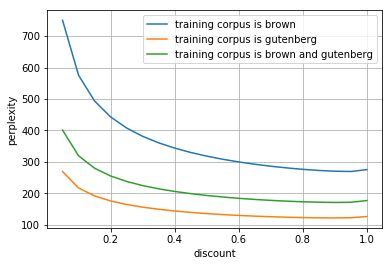

The lowest perplexity in cross validation set is 171.17501889103136 corresponding to discount of 0.9 when training corpus is brown and gutenberg
129.68811537042208


In [30]:
text_gutenberg=list(gutenberg.sents())
text_brown=list(brown.sents())
text_gutenberg_size=len(text_gutenberg)
text_gutenberg_size=len(text_gutenberg)
text_brown_size=len(text_brown)
for i in range(text_gutenberg_size):
    text_gutenberg[i].insert(0,"<s>")
    text_gutenberg[i].insert(len(text_gutenberg[i]),'<e>')
    text_gutenberg[i].insert(len(text_gutenberg[i]),'<e>')
for i in range(text_brown_size):
    text_brown[i].insert(0,"<s>")
    text_brown[i].insert(len(text_brown[i]),'<e>')
    text_brown[i].insert(len(text_brown[i]),'<e>')
text_gutenberg_tr,text_gutenberg_te=train_test_split(text_gutenberg,test_size=.20,random_state=4)
text_brown_tr,text_brown_te=train_test_split(text_brown,test_size=.20,random_state=4)

plt.close()
print(findperplexity_KN(text_brown_tr,text_brown_te,"training corpus is brown"))
print(findperplexity_KN(text_gutenberg_tr,text_gutenberg_te,"training corpus is gutenberg"))
print(findperplexity_KN(text_brown_tr+text_gutenberg_tr,text_brown_te,"training corpus is brown and gutenberg"))
plt.show()
plt.close()
print(findperplexity_KN(text_brown_tr+text_gutenberg_tr,text_gutenberg_te,"training corpus is brown and gutenberg"))
plt.close()


In [96]:
x=tg_keys[90]
x1=(x[0],x[1])
prob=0
for tg in tg_keys:
    if(((tg[0],tg[1])==x1)):
        prob=prob+findPKn_trigram(tg)
print(prob)

0.9616023202772355
